# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

In [3]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=42)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=42)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_train = pd.concat([df2_train[df2_train['label'] == 0].sample(n=2000, random_state=42), df2_train[df2_train['label'] == 1]])  ####
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# # transform the dataset
sampler = RandomOverSampler()
df2_train, _ = sampler.fit_resample(df2_train, df2_train['label'])

In [4]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=42)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=42)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# transform the dataset
sampler = RandomOverSampler()
df2_train, _ = sampler.fit_resample(df2_train, df2_train['label'])

In [4]:
# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']], df3_train['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# 2. Encoding

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # # Cvec encoding
# Cvec = CountVectorizer()
# x_train = Cvec.fit_transform(x_tr)
# x_dev = Cvec.transform(x_dev)

# # Tvec encoding
Tvec = TfidfVectorizer(ngram_range=(1,5))
x_train = Tvec.fit_transform(x_tr)
x_dev = Tvec.transform(x_dev)

# 3 DL Models (Embeding model)

In [7]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
device = 'cpu'
torch.manual_seed(42)

In [8]:
# # Weights function
# def weights(df):
#     w = list(len(df['label'])/df['label'].value_counts())
#     sample_weights = [0] * df.shape[0]
#     for idx, label in enumerate(df['label']):
#         sample_weights[idx] = w[label]
#     return sample_weights

# Dataset to TensorDataset
train_DS = TensorDataset(torch.from_numpy(x_train.todense()).float(), torch.from_numpy(np.array(y_train)).float().reshape(-1,1))
dev_DS = TensorDataset(torch.from_numpy(x_dev.todense()).float(), torch.from_numpy(np.array(y_dev)).float().reshape(-1,1))

# Sample data
# sampler_tr = torch.utils.data.WeightedRandomSampler(weights(df3_train), num_samples=len(train_DS), replacement=True)
# sampler_ts = torch.utils.data.WeightedRandomSampler(weights(dev_set), num_samples=len(dev_DS), replacement=True)

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs)
x_dev_dl = DataLoader(dev_DS, batch_size=bs)


# x_tr_dl = DataLoader(train_DS, batch_size=bs, sampler=sampler_tr)
# x_dev_dl = DataLoader(dev_DS, batch_size=bs, sampler=sampler_ts)

In [9]:
from torch import nn
class BowNetwork(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.first_layer = nn.Linear(vocab_size, hidden_dim) 
        nn.init.uniform_(self.first_layer.weight)
        self.second_layer = nn.Linear(hidden_dim, hidden_dim)
        self.third_layer = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.first_layer(x)) 
        x = torch.relu(self.second_layer(x))
        logits = self.third_layer(x)
        return self.dropout(logits)

In [10]:
vocab_size = x_train.shape[1]
bow_model = BowNetwork(vocab_size, 64).to(device)
print(bow_model)

BowNetwork(
  (first_layer): Linear(in_features=79006, out_features=64, bias=True)
  (second_layer): Linear(in_features=64, out_features=64, bias=True)
  (third_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [19]:
# Optimizer
optimizer = torch.optim.Adam(bow_model.parameters())

def weights_class(y):
    y = pd.Series(y.int().numpy(force=True).reshape(-1))
    w = len(y)/y.value_counts()
    try:
        return w[1]
        
    except:
        return 0

In [20]:
from sklearn.metrics import f1_score
from tqdm import tqdm
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, total, acc, real, preds = 0, 0, 0, [], []
    for X, y in tqdm(dataloader):
        pred = model(X)                                             # Forward pass
        loss_fn = nn.BCEWithLogitsLoss(weight = torch.tensor(weights_class(y)).to(device))
        loss = loss_fn(pred, y)                                     # Compute loss 
        loss.backward()                                             # Backpropagation
        optimizer.step()                                            # Update parameters
        optimizer.zero_grad()                                       # Reset gradient
        # Metrics
        pr = torch.sigmoid(pred)
        acc += torch.sum((pr>=0.5).float() == y)
        real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        preds.extend((pr>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        train_loss += loss.item()
        total += len(y)
    # General metrics
    train_loss /= total
    return train_loss, acc/size, f1_score(real, preds)

In [21]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, total, acc, real, preds = 0, 0, 0, [], []
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            
            pred = model(X)                                         # Forward pass
            loss_fn = nn.BCEWithLogitsLoss(weight = torch.tensor(weights_class(y)).to(device))
            
            # Metrics
            pr = torch.sigmoid(pred)
            acc += torch.sum((pr>=0.5).float() == y)
            real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            preds.extend((pr>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            
            test_loss += loss_fn(pred, y).item()    # Compute loss  
            total += len(y)                         # Total observations

    # General metrics
    test_loss /= total
    return test_loss, acc/size, f1_score(real, preds)

In [22]:
from tqdm import tqdm # show progress bar

# Epochs
epochs = 100
train_loss, valid_loss = [], []
print("Training BOW feedforward network model!")
for t in range(epochs):
    tl, train_acc, f1_tr = train(x_tr_dl, bow_model, optimizer)
    vl, valid_acc, f1_ts = test(x_dev_dl, bow_model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )
    tqdm.write(
        f'epoch #{t}\tf1_tr: {f1_tr:.3f}\t\tf1_ts: {f1_ts:.3f}',
    )

Training BOW feedforward network model!


100%|██████████| 813/813 [00:20<00:00, 40.31it/s]


epoch #0	train_acc: 0.512	valid_acc: 0.500
epoch #0	f1_tr: 0.651		f1_ts: 0.667


100%|██████████| 813/813 [00:20<00:00, 40.58it/s]


epoch #1	train_acc: 0.582	valid_acc: 0.501
epoch #1	f1_tr: 0.696		f1_ts: 0.667


100%|██████████| 813/813 [00:20<00:00, 39.87it/s]


epoch #2	train_acc: 0.902	valid_acc: 0.501
epoch #2	f1_tr: 0.907		f1_ts: 0.667


100%|██████████| 813/813 [00:20<00:00, 39.39it/s]


epoch #3	train_acc: 0.914	valid_acc: 0.502
epoch #3	f1_tr: 0.919		f1_ts: 0.667


100%|██████████| 813/813 [00:20<00:00, 40.20it/s]


epoch #4	train_acc: 0.814	valid_acc: 0.600
epoch #4	f1_tr: 0.842		f1_ts: 0.706


100%|██████████| 813/813 [00:20<00:00, 39.43it/s]


epoch #5	train_acc: 0.585	valid_acc: 0.635
epoch #5	f1_tr: 0.705		f1_ts: 0.715


100%|██████████| 813/813 [00:20<00:00, 39.66it/s]


epoch #6	train_acc: 0.663	valid_acc: 0.649
epoch #6	f1_tr: 0.747		f1_ts: 0.709


100%|██████████| 813/813 [00:20<00:00, 39.67it/s]


epoch #7	train_acc: 0.591	valid_acc: 0.652
epoch #7	f1_tr: 0.709		f1_ts: 0.710


100%|██████████| 813/813 [00:21<00:00, 38.32it/s]


epoch #8	train_acc: 0.582	valid_acc: 0.647
epoch #8	f1_tr: 0.705		f1_ts: 0.708


100%|██████████| 813/813 [00:20<00:00, 39.70it/s]


epoch #9	train_acc: 0.645	valid_acc: 0.628
epoch #9	f1_tr: 0.737		f1_ts: 0.667


100%|██████████| 813/813 [00:20<00:00, 40.23it/s]


epoch #10	train_acc: 0.598	valid_acc: 0.629
epoch #10	f1_tr: 0.713		f1_ts: 0.669


100%|██████████| 813/813 [00:20<00:00, 39.79it/s]


epoch #11	train_acc: 0.589	valid_acc: 0.641
epoch #11	f1_tr: 0.708		f1_ts: 0.691


100%|██████████| 813/813 [00:20<00:00, 40.34it/s]


epoch #12	train_acc: 0.597	valid_acc: 0.636
epoch #12	f1_tr: 0.712		f1_ts: 0.680


100%|██████████| 813/813 [00:20<00:00, 39.99it/s]


epoch #13	train_acc: 0.584	valid_acc: 0.637
epoch #13	f1_tr: 0.706		f1_ts: 0.689


100%|██████████| 813/813 [00:20<00:00, 40.20it/s]


epoch #14	train_acc: 0.593	valid_acc: 0.637
epoch #14	f1_tr: 0.710		f1_ts: 0.682


100%|██████████| 813/813 [00:22<00:00, 35.88it/s]


epoch #15	train_acc: 0.630	valid_acc: 0.616
epoch #15	f1_tr: 0.730		f1_ts: 0.639


100%|██████████| 813/813 [00:23<00:00, 34.89it/s]


epoch #16	train_acc: 0.580	valid_acc: 0.638
epoch #16	f1_tr: 0.704		f1_ts: 0.706


100%|██████████| 813/813 [00:23<00:00, 33.99it/s]


epoch #17	train_acc: 0.593	valid_acc: 0.636
epoch #17	f1_tr: 0.710		f1_ts: 0.682


100%|██████████| 813/813 [00:25<00:00, 32.01it/s]


epoch #18	train_acc: 0.589	valid_acc: 0.643
epoch #18	f1_tr: 0.709		f1_ts: 0.695


100%|██████████| 813/813 [00:27<00:00, 29.49it/s]


epoch #19	train_acc: 0.601	valid_acc: 0.638
epoch #19	f1_tr: 0.715		f1_ts: 0.686


100%|██████████| 813/813 [00:25<00:00, 31.66it/s]


epoch #20	train_acc: 0.587	valid_acc: 0.647
epoch #20	f1_tr: 0.708		f1_ts: 0.708


100%|██████████| 813/813 [00:24<00:00, 33.77it/s]


epoch #21	train_acc: 0.607	valid_acc: 0.634
epoch #21	f1_tr: 0.718		f1_ts: 0.673


100%|██████████| 813/813 [00:24<00:00, 33.77it/s]


epoch #22	train_acc: 0.582	valid_acc: 0.642
epoch #22	f1_tr: 0.705		f1_ts: 0.715


100%|██████████| 813/813 [00:23<00:00, 34.93it/s]


epoch #23	train_acc: 0.612	valid_acc: 0.637
epoch #23	f1_tr: 0.721		f1_ts: 0.676


100%|██████████| 813/813 [00:23<00:00, 35.23it/s]


epoch #24	train_acc: 0.584	valid_acc: 0.647
epoch #24	f1_tr: 0.706		f1_ts: 0.714


100%|██████████| 813/813 [00:23<00:00, 35.17it/s]


epoch #25	train_acc: 0.580	valid_acc: 0.635
epoch #25	f1_tr: 0.704		f1_ts: 0.711


100%|██████████| 813/813 [00:23<00:00, 34.65it/s]


epoch #26	train_acc: 0.592	valid_acc: 0.646
epoch #26	f1_tr: 0.710		f1_ts: 0.701


100%|██████████| 813/813 [00:24<00:00, 33.46it/s]


epoch #27	train_acc: 0.577	valid_acc: 0.627
epoch #27	f1_tr: 0.703		f1_ts: 0.708


100%|██████████| 813/813 [00:25<00:00, 32.32it/s]


epoch #28	train_acc: 0.585	valid_acc: 0.649
epoch #28	f1_tr: 0.706		f1_ts: 0.713


100%|██████████| 813/813 [00:24<00:00, 32.87it/s]


epoch #29	train_acc: 0.589	valid_acc: 0.652
epoch #29	f1_tr: 0.709		f1_ts: 0.712


100%|██████████| 813/813 [00:24<00:00, 33.70it/s]


epoch #30	train_acc: 0.585	valid_acc: 0.651
epoch #30	f1_tr: 0.707		f1_ts: 0.716


100%|██████████| 813/813 [00:25<00:00, 32.14it/s]


epoch #31	train_acc: 0.579	valid_acc: 0.630
epoch #31	f1_tr: 0.704		f1_ts: 0.712


100%|██████████| 813/813 [00:26<00:00, 31.10it/s]


epoch #32	train_acc: 0.597	valid_acc: 0.634
epoch #32	f1_tr: 0.713		f1_ts: 0.679


100%|██████████| 813/813 [00:27<00:00, 29.84it/s]


epoch #33	train_acc: 0.611	valid_acc: 0.623
epoch #33	f1_tr: 0.720		f1_ts: 0.659


100%|██████████| 813/813 [00:26<00:00, 30.37it/s]


epoch #34	train_acc: 0.619	valid_acc: 0.627
epoch #34	f1_tr: 0.724		f1_ts: 0.670


100%|██████████| 813/813 [00:25<00:00, 32.11it/s]


epoch #35	train_acc: 0.589	valid_acc: 0.646
epoch #35	f1_tr: 0.709		f1_ts: 0.702


100%|██████████| 813/813 [00:25<00:00, 32.09it/s]


epoch #36	train_acc: 0.577	valid_acc: 0.629
epoch #36	f1_tr: 0.703		f1_ts: 0.709


100%|██████████| 813/813 [00:25<00:00, 31.82it/s]


epoch #37	train_acc: 0.598	valid_acc: 0.632
epoch #37	f1_tr: 0.713		f1_ts: 0.678


 11%|█         | 86/813 [00:02<00:24, 30.19it/s]


KeyboardInterrupt: 

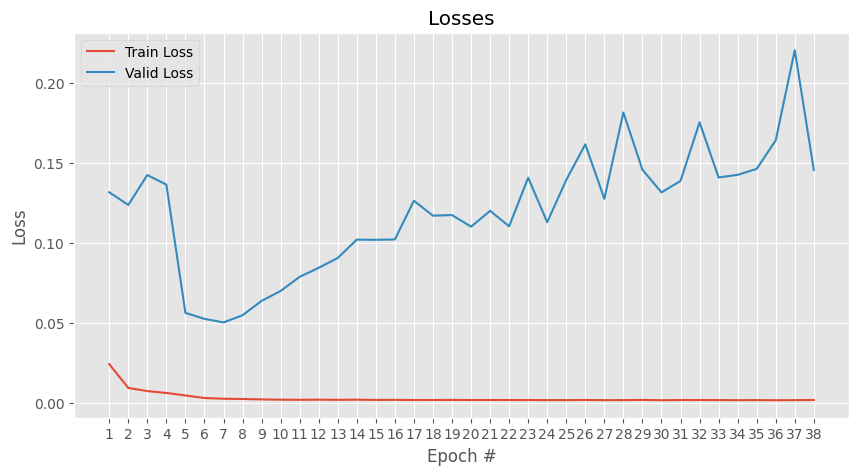

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, t + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# Predict on sample data

In [ ]:
# Predict on sample data
# Read data
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in pd.read_json('test_data.json', lines=True)['text']]
# Encoding
x_test = torch.from_numpy(Cvec.transform(test).todense()).float()
# Predict
x_pred = [int(i) for i in (bow_model(x_test)>0.5).float()]
# Create DF
df = pd.DataFrame([[i,j] for i,j in enumerate(x_pred)], columns=['id', 'class'])
# Save file
df.to_csv('predictions.csv', index=False)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [93]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

df1['domain'], df2['domain'] = 0, 1
df3 = pd.concat([df1, df2])

In [94]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, random_state=42, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=42)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=42)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_train = pd.concat([df2_train[df2_train['label'] == 0].sample(n=2000, random_state=42), df2_train[df2_train['label'] == 1]])  ####
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# # transform the dataset
sampler = RandomOverSampler()
df2_train, _ = sampler.fit_resample(df2_train, df2_train['label'])

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']], df3_train['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

In [95]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # Cvec encoding
# Cvec = CountVectorizer(ngram_range=(1,3))
# x_train = Cvec.fit_transform(x_tr)
# x_dev = Cvec.transform(x_dev)

# Tvec encoding
Tvec = TfidfVectorizer()
x_train = Tvec.fit_transform(x_tr)
# x_dev = Tvec.transform(x_dev)

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(3, svd_solver='arpack')
comps = pca.fit_transform(StandardScaler(with_mean=False).fit_transform(x_train))

# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=3)
# comps = svd.fit_transform(x_train)

# from sklearn.cross_decomposition import PLSCanonical
# plsca = PLSCanonical(n_components=1)
# comps = plsca.fit(x_train.toarray(), y_train)

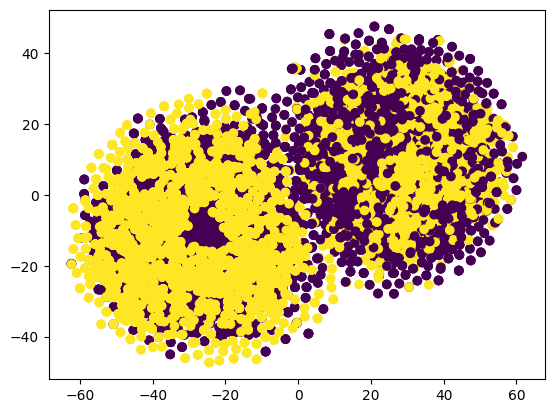

In [103]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# t-SNE
perplexity = 150
t_sne = TSNE(n_components=2, perplexity=perplexity, init="random")
comps = t_sne.fit_transform(x_train)

plt.scatter(comps.T[0], comps.T[1], c= df3_train['label'])

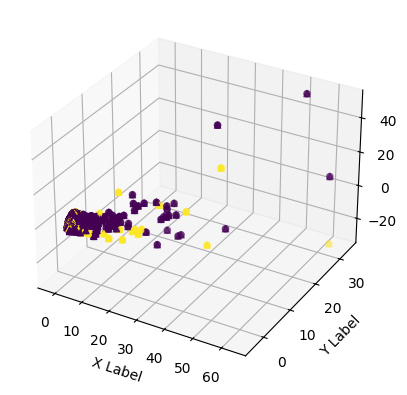

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = comps.T[0]
    ys = comps.T[1]
    zs = comps.T[2]
    ax.scatter(xs, ys, zs, marker=m, c=df3['label'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()